In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
#read in data
players = pd.read_csv("players.csv")
games = pd.read_csv("games.csv")
player_play = pd.read_csv("player_play.csv")
plays = pd.read_csv("plays.csv")

player_play = player_play.merge(games[['gameId', 'week']], on = 'gameId', how = 'left')

weeks = [1]
# Read and concatenate all weeks into one DataFrame
all_weeks = pd.concat(
    [pd.read_csv(f"tracking_week_{w}.csv").assign(week=w) for w in weeks],
    ignore_index=True
)

# Transform 'y' based on play direction
all_weeks['y'] = np.where(all_weeks['playDirection'] == 'right',
                      all_weeks['y'],
                      53.3 - all_weeks['y'])

# Transform 'x' based on play direction
all_weeks['x'] = np.where(all_weeks['playDirection'] == 'right',
                      all_weeks['x'],
                      120 - all_weeks['x'])

# Adjust orientation 'o' based on play direction
all_weeks['o'] = np.where(all_weeks['playDirection'] == 'right',
                      all_weeks['o'],
                      (all_weeks['o'] + 180) % 360)

# Adjust direction 'dir' based on play direction
all_weeks['dir'] = np.where(all_weeks['playDirection'] == 'right',
                        all_weeks['dir'],
                        (all_weeks['dir'] + 180) % 360)


def fix_time_format(time_str):
    if pd.isna(time_str):
        return time_str  # Keep NaT as is
    if '.' not in time_str:
        return time_str + '.000'  # Add tenths of seconds if missing
    return time_str

all_weeks['time'] = all_weeks['time'].apply(fix_time_format)

all_weeks['time'] = pd.to_datetime(all_weeks['time'], errors='coerce')

In [4]:
#Find Dropbacks

all_dropbacks = player_play[player_play['hadDropback']==1][['gameId', 'playId', 'nflId', 'hadDropback', 'week']].merge(players[['nflId', 'displayName', 'position']], on = 'nflId')
qb_dropbacks = all_dropbacks[all_dropbacks['position'] == 'QB']
qb_dropbacks = qb_dropbacks[qb_dropbacks['displayName'] != 'Tua Tagovailoa']
qb_dropbacks

,gameId,playId,nflId,hadDropback,week,displayName,position
0,2022090800,56,46076,1,1,Josh Allen,QB
1,2022090800,122,46076,1,1,Josh Allen,QB
2,2022090800,167,46076,1,1,Josh Allen,QB
3,2022090800,212,46076,1,1,Josh Allen,QB
4,2022090800,236,46076,1,1,Josh Allen,QB
...,...,...,...,...,...,...,...
6228,2022110700,3299,37110,1,9,Andy Dalton,QB
6229,2022110700,3323,37110,1,9,Andy Dalton,QB
6230,2022110700,3347,37110,1,9,Andy Dalton,QB
6231,2022110700,3401,37110,1,9,Andy Dalton,QB


/var/folders/nx/9q47sdzn7rd9vcwgb2h8jhhc0000gn/T/ipykernel_65694/1568260100.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.loc[:df[df['event'].isin(end_events)].index.min()] if not df[df['event'].isin(end_events)].empty else df)
/var/folders/nx/9q47sdzn7rd9vcwgb2h8jhhc0000gn/T/ipykernel_65694/1568260100.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[df['

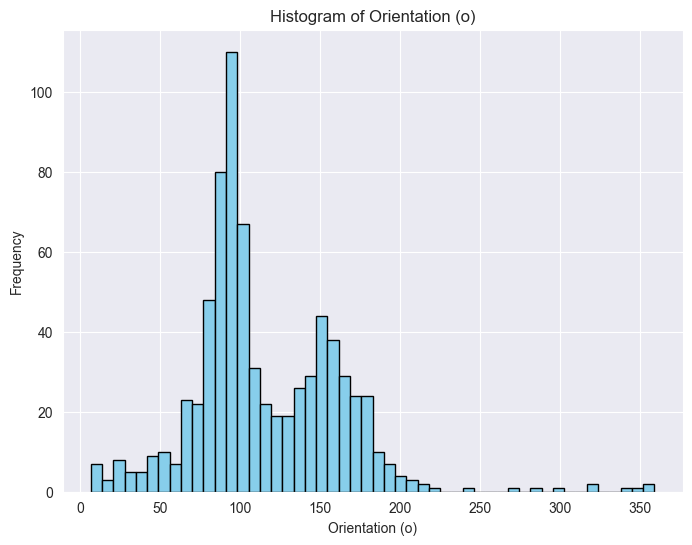

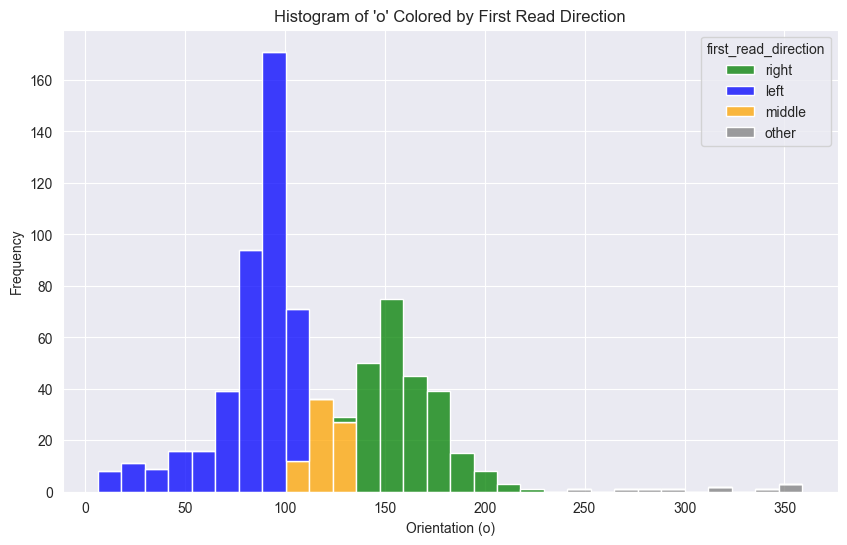

In [5]:
dropbacks_tracking2 = pd.merge(qb_dropbacks, all_weeks, on=['gameId', 'playId', 'nflId', 'displayName'], how='inner')

#This time we're just looking at one orientation, which is when the qb reaches the deepest point of their drop

# Define the set of events that indicate the play has progressed past the dropback
end_events = {'pass_forward', 'tackle', 'first_contact', 'out_of_bounds', 'qb_sack',
              'fumble', 'qb_strip_sack', 'lateral', 'handoff', 'pass_shovel', 'run'}

# Filter data to only AFTER_SNAP frames and stop at the first of these events for each play
filtered_tracking = (
    dropbacks_tracking2[dropbacks_tracking2['frameType'] == 'AFTER_SNAP']
    .sort_values(['gameId', 'playId', 'time'])  # Sort by play and time
    .groupby(['gameId', 'playId'])
    .apply(lambda df: df.loc[:df[df['event'].isin(end_events)].index.min()] if not df[df['event'].isin(end_events)].empty else df)
    .reset_index(drop=True)
)


# Find the initial forward orientation within this filtered data
initial_forward_orientations = (
    filtered_tracking[(filtered_tracking['dir'] > 0) & (filtered_tracking['dir'] < 180)]
    .sort_values(['gameId', 'playId', 'time'])  # Sort by play and time
    .groupby(['gameId', 'playId'])
    .first()[['dir', 'dis', 'o', 'time']]  # Get the earliest timestamp with forward motion
    .reset_index()
)

# For plays where no forward motion is found, get the first event that ends the dropback
no_forward_motion_plays = (
    filtered_tracking.groupby(['gameId', 'playId'])
    .filter(lambda df: ((df['dir'] <= 0) | (df['dir'] >= 180)).all())  # No forward motion
    .sort_values(['gameId', 'playId', 'time'])
    .groupby(['gameId', 'playId'])
    .apply(lambda df: df[df['event'].isin(end_events)].iloc[0] if not df[df['event'].isin(end_events)].empty else df.iloc[0])  # Get the first event from end_events only
    .reset_index(drop=True)[['gameId', 'playId', 'dir', 'dis', 'o', 'time', 'event']]
)

# Combine results, with forward orientations and fallback to first event where needed
final_orientations = pd.concat([initial_forward_orientations, no_forward_motion_plays], ignore_index=True)

# Plot a histogram for the 'o' column
plt.figure(figsize=(8, 6))
plt.hist(final_orientations['o'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Orientation (o)')
plt.xlabel('Orientation (o)')
plt.ylabel('Frequency')
plt.show()


final_orientations['first_read_direction'] = final_orientations['o'].apply(
    lambda o: 'left' if 0 <= o <= 110 else
              'right' if 135 <= o <= 225 else
              'middle' if 110 < o < 135 else
              'other'
)

# Assign colors to each category
color_map = {
    'left': 'blue',
    'right': 'green',
    'middle': 'orange',
    'other': 'gray'
}

# Add colors for each `first_read_direction`
final_orientations['color'] = final_orientations['first_read_direction'].map(color_map)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=final_orientations,
    x='o',
    hue='first_read_direction',
    palette=color_map,
    bins=30,
    multiple='stack'  # Stacks the sections in the histogram
)

# Customize plot
plt.title("Histogram of 'o' Colored by First Read Direction")
plt.xlabel("Orientation (o)")
plt.ylabel("Frequency")
plt.show()

In [6]:
def find_offense_motion(game_id, play_id, tracking_data, offense_club):
    """
    Identify the offensive player in motion on the snap of a given play, along with
    the horizontal distance traveled and motion direction (right/left relative to the ball).

    Parameters:
    - game_id: int, game identifier
    - play_id: int, play identifier
    - tracking_data: DataFrame, tracking dataset
    - offense_club: str, offensive team's abbreviation

    Returns:
    - dict: Information about the top player in motion, including nflId, displayName,
            horizontal_distance_traveled (R/L distinction), or None if no motion detected.
    """
    # Filter tracking data for the specific play and offense
    play_data = tracking_data[
        (tracking_data['gameId'] == game_id) &
        (tracking_data['playId'] == play_id) &
        (tracking_data['club'] == offense_club)
    ]

    # Return if play data is not available
    if play_data.empty:
        return "Not in tracking dataset"

    # Identify the snap time
    snap_event = play_data[play_data['event'] == 'ball_snap']
    if snap_event.empty:
        return "No ball_snap event found"
    snap_time = snap_event['time'].iloc[0]

    # Filter data for the 0.9s to 0.1s pre-snap window
    pre_snap_data = play_data[
        (play_data['time'] >= snap_time - pd.Timedelta(seconds=0.9)) &
        (play_data['time'] <= snap_time - pd.Timedelta(seconds=0.1))
    ]

    # Summarize motion distances
    motion_summary = (
        pre_snap_data.groupby(['nflId', 'displayName'])
        .agg(total_dis=('dis', 'sum'))
        .reset_index()
        .sort_values(by='total_dis', ascending=False)
    )

    # Identify top player if total motion distance > 1.5
    top_player = motion_summary[motion_summary['total_dis'] > 1.5].head(1)
    if not top_player.empty:
        # Get the relevant player's nflId and displayName
        player_data = top_player.iloc[0]
        nfl_id = player_data['nflId']
        display_name = player_data['displayName']

        # Now calculate the horizontal distance traveled (relative to the ball)
        player_data_for_motion = play_data[play_data['nflId'] == nfl_id]

        # Position at 0.9s before snap
        position_before = player_data_for_motion[
            player_data_for_motion['time'] == (snap_time - pd.Timedelta(seconds=0.9))
        ]

        # Position at 0.1s before snap
        position_after = player_data_for_motion[
            player_data_for_motion['time'] == (snap_time - pd.Timedelta(seconds=0.1))
        ]

        if not position_before.empty and not position_after.empty:
            # Calculate horizontal distance (y-axis difference)
            y_before = position_before['y'].iloc[0]
            y_after = position_after['y'].iloc[0]
            horizontal_distance_traveled = y_after - y_before

            # Determine direction: Right (negative distance) or Left (positive distance)
            direction = 'R' if horizontal_distance_traveled < 0 else 'L'

            # Return a dictionary with all relevant information
            return {
                'nflId': nfl_id,
                'displayName': display_name,
                'horizontal_distance_traveled': horizontal_distance_traveled,
                'direction': direction
            }

    return None

In [7]:
orientations_motions = final_orientations.merge(
    plays[['gameId', 'playId', 'possessionTeam']],  # Select necessary columns from play_data
    on=['gameId', 'playId'],  # Merge keys
    how='left'  # Use 'left' join to retain all rows in final_orientations
)
orientations_motions = orientations_motions.merge(games[['gameId', 'week']], on = 'gameId', how = 'left')
orientations_motions

,gameId,playId,dir,dis,o,time,event,first_read_direction,color,possessionTeam,week
0,2022090800,56,151.54,0.03,182.28,2022-09-09 00:24:04.400,NaN,right,green,BUF,1
1,2022090800,122,71.99,0.00,84.63,2022-09-09 00:25:47.800,NaN,left,blue,BUF,1
2,2022090800,167,103.91,0.00,88.24,2022-09-09 00:27:08.300,NaN,left,blue,BUF,1
3,2022090800,212,128.12,0.02,188.37,2022-09-09 00:28:22.400,NaN,right,green,BUF,1
4,2022090800,364,78.35,0.01,113.63,2022-09-09 00:35:12.100,NaN,middle,orange,LA,1
...,...,...,...,...,...,...,...,...,...,...,...
741,2022091200,3467,197.11,0.56,126.89,2022-09-13 02:47:31.100,pass_forward,middle,orange,SEA,1
742,2022091200,3491,256.58,0.23,153.48,2022-09-13 02:48:07.500,pass_forward,right,green,SEA,1
743,2022091200,3596,211.47,0.18,166.46,2022-09-13 02:54:09.800,pass_forward,right,green,DEN,1
744,2022091200,3628,189.90,0.03,143.82,2022-09-13 02:58:30.500,pass_forward,right,green,DEN,1


In [8]:
# Loop through each unique week in 'all_weeks'
for week in all_weeks['week'].unique():
    # Filter the data for the current week
    week_data = all_weeks[all_weeks['week'] == week]
    qb_dropbacks_week = qb_dropbacks[qb_dropbacks['week'] == week]
    player_play_week = player_play[player_play['week'] == week]
    orientations_motions_week = orientations_motions[orientations_motions['week'] == week].copy()  # Ensure a copy is made

    # Merge dropbacks data for the current week
    dropback_week_data = week_data.merge(qb_dropbacks_week[['gameId', 'playId']], on=['gameId', 'playId'], how='inner')

    # Filter out 'AFTER_SNAP' frameType for presnap data
    presnap_dropback_week_data = dropback_week_data[dropback_week_data['frameType'] != 'AFTER_SNAP']

    # Apply motion calculation for the current week
    orientations_motions_week.loc[:, 'motion_player_dict'] = orientations_motions_week.apply(
        lambda row: find_offense_motion(row['gameId'], row['playId'], presnap_dropback_week_data, row['possessionTeam']), axis=1
    )

    # Extract motion data for the current week
    orientations_motions_week.loc[:, 'motion_nflId'] = orientations_motions_week['motion_player_dict'].apply(
        lambda x: x['nflId'] if isinstance(x, dict) else None
    )
    orientations_motions_week.loc[:, 'motion_displayName'] = orientations_motions_week['motion_player_dict'].apply(
        lambda x: x['displayName'] if isinstance(x, dict) else None
    )
    orientations_motions_week.loc[:, 'motion_horizontal_distance_traveled'] = orientations_motions_week['motion_player_dict'].apply(
        lambda x: x['horizontal_distance_traveled'] if isinstance(x, dict) else None
    )
    orientations_motions_week.loc[:, 'motion_direction'] = orientations_motions_week['motion_player_dict'].apply(
        lambda x: x['direction'] if isinstance(x, dict) else None
    )

    # Drop the intermediate column
    orientations_motions_week.drop(columns=['motion_player_dict'], inplace=True)

    # Merge with defensive coverage data for the current week
    orientations_motions_week = orientations_motions_week.merge(
        player_play_week[['gameId', 'playId', 'nflId', 'pff_primaryDefensiveCoverageMatchupNflId']],
        left_on=['gameId', 'playId', 'motion_nflId'],
        right_on=['gameId', 'playId', 'nflId']
    )

    # Collect processed week data
    if week == 1:
        all_processed_weeks = orientations_motions_week
    else:
        all_processed_weeks = pd.concat([all_processed_weeks, orientations_motions_week], ignore_index=True)


orientations_motions = all_processed_weeks
orientations_motions

,gameId,playId,dir,dis,o,time,event,first_read_direction,color,possessionTeam,week,motion_nflId,motion_displayName,motion_horizontal_distance_traveled,motion_direction,nflId,pff_primaryDefensiveCoverageMatchupNflId
0,2022090800,212,128.12,0.02,188.37,2022-09-09 00:28:22.400,NaN,right,green,BUF,1,47879.0,Dawson Knox,-5.08,R,47879,NaN
1,2022090800,438,179.03,0.04,159.88,2022-09-09 00:36:58.300,NaN,right,green,LA,1,53678.0,Ben Skowronek,3.91,L,53678,NaN
2,2022090800,569,112.31,0.00,94.28,2022-09-09 00:42:57.200,NaN,left,blue,BUF,1,42489.0,Stefon Diggs,-3.14,R,42489,NaN
3,2022090800,617,74.65,0.02,90.00,2022-09-09 00:44:11.400,NaN,left,blue,BUF,1,44985.0,Isaiah McKenzie,4.83,L,44985,NaN
4,2022090800,692,122.55,0.00,88.24,2022-09-09 00:45:58.400,NaN,left,blue,BUF,1,42489.0,Stefon Diggs,-5.10,R,42489,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2022091200,3048,312.75,0.05,159.04,2022-09-13 02:32:04.500,pass_forward,right,green,DEN,1,52423.0,Jerry Jeudy,-4.76,R,52423,NaN
171,2022091200,3216,223.93,0.29,131.13,2022-09-13 02:37:13.300,pass_forward,middle,orange,DEN,1,52423.0,Jerry Jeudy,-2.11,R,52423,NaN
172,2022091200,3296,279.15,0.26,154.38,2022-09-13 02:39:25.400,pass_forward,right,green,DEN,1,52423.0,Jerry Jeudy,-1.70,R,52423,NaN
173,2022091200,3491,256.58,0.23,153.48,2022-09-13 02:48:07.500,pass_forward,right,green,SEA,1,46096.0,Rashaad Penny,4.03,L,46096,NaN


In [9]:
just_orientations_motions = orientations_motions[['gameId', 'playId', 'first_read_direction', 'motion_direction']]
just_orientations_motions = just_orientations_motions[just_orientations_motions['motion_direction'].notna()]
just_orientations_motions = just_orientations_motions[just_orientations_motions['first_read_direction'].isin(['right', 'left'])]
just_orientations_motions = just_orientations_motions.merge(plays[['gameId', 'playId', 'pff_manZone', 'expectedPointsAdded']], on = ['gameId', 'playId'], how = 'left')
just_orientations_motions = just_orientations_motions[just_orientations_motions['pff_manZone'] == 'Man']

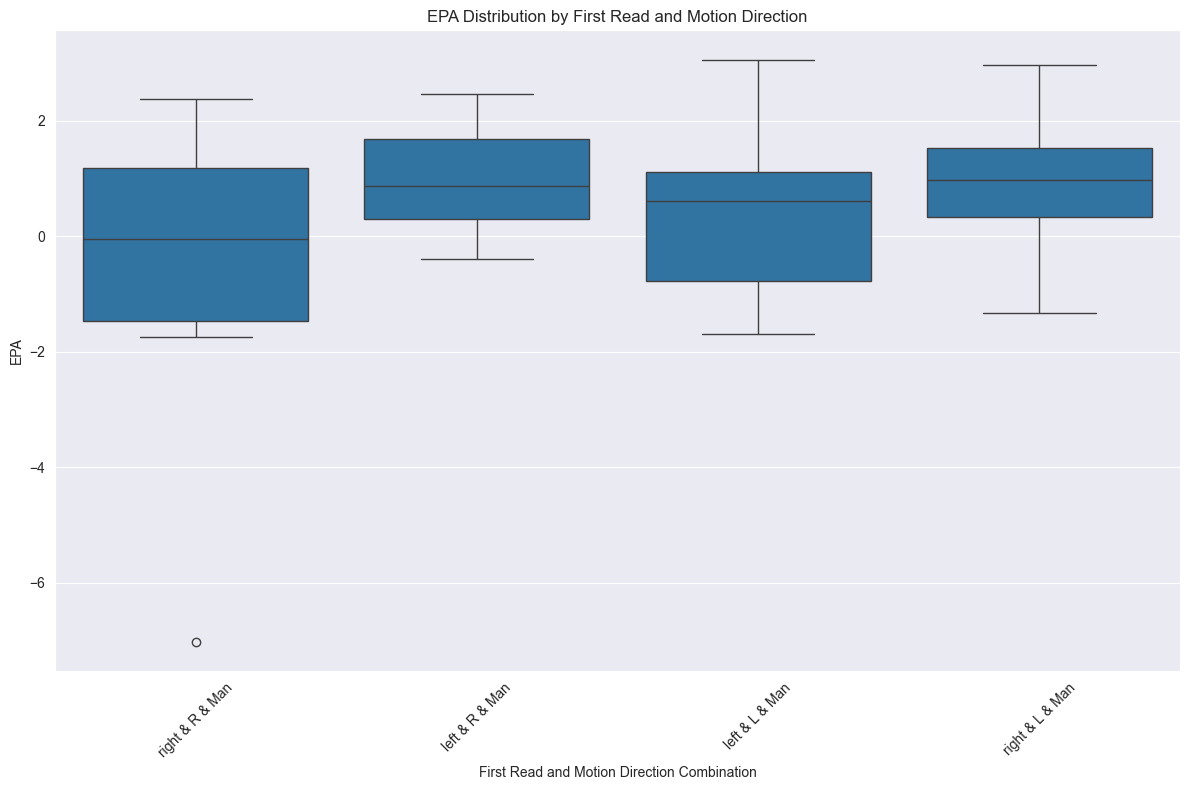

In [10]:
# Create a new column combining the two categorical variables
just_orientations_motions['direction_combination'] = (
    just_orientations_motions['first_read_direction'] + ' & ' + just_orientations_motions['motion_direction'] + ' & ' + just_orientations_motions['pff_manZone']
)

# Create the box plots for each combination of first_read_direction and motion_direction
plt.figure(figsize=(12, 8))

# Plot the box plot
sns.boxplot(x='direction_combination', y='expectedPointsAdded', data=just_orientations_motions)

# Customize the plot
plt.title('EPA Distribution by First Read and Motion Direction')
plt.xlabel('First Read and Motion Direction Combination')
plt.ylabel('EPA')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Ensure everything fits

# Show the plot
plt.show()

In [11]:
just_orientations_motions = orientations_motions[['gameId', 'playId', 'first_read_direction', 'motion_direction']]
just_orientations_motions = just_orientations_motions[just_orientations_motions['motion_direction'].notna()]
just_orientations_motions = just_orientations_motions[just_orientations_motions['first_read_direction'].isin(['right', 'left'])]
just_orientations_motions = just_orientations_motions.merge(plays[['gameId', 'playId', 'pff_manZone', 'expectedPointsAdded']], on = ['gameId', 'playId'], how = 'left')
just_orientations_motions = just_orientations_motions[just_orientations_motions['pff_manZone'] == 'Zone']

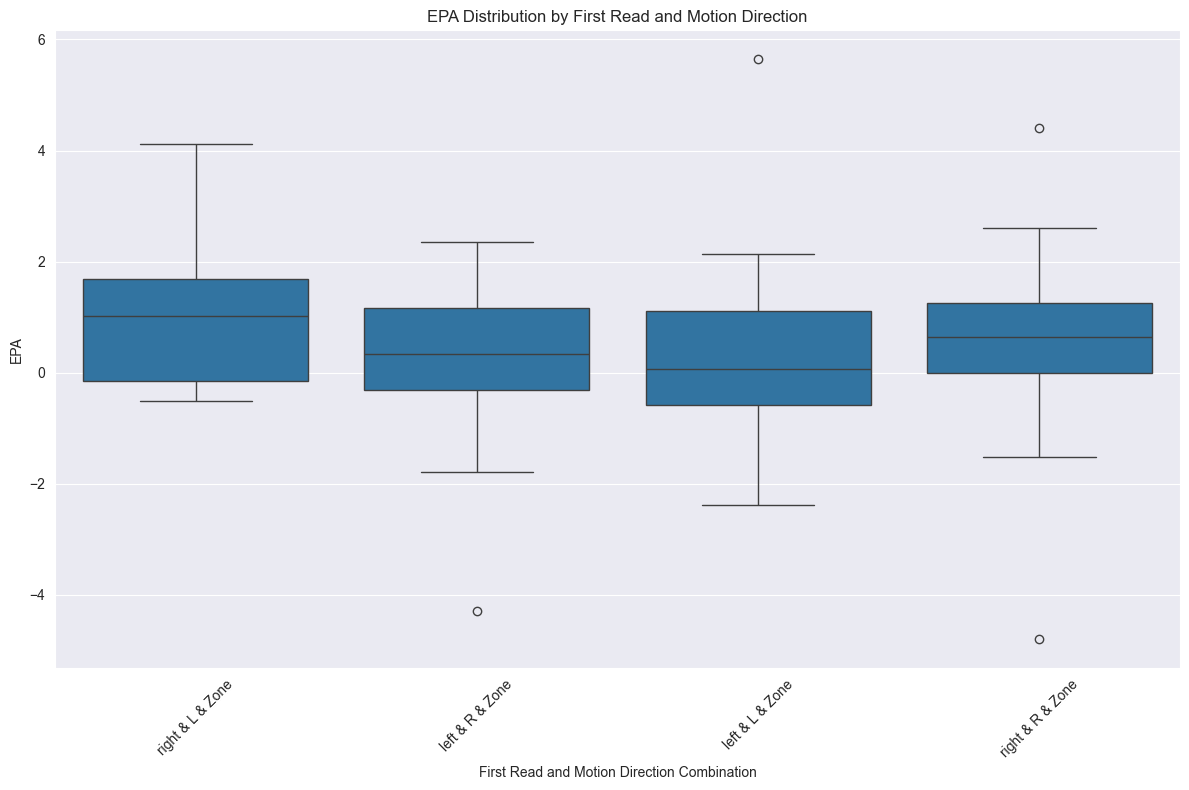

In [12]:
# Create a new column combining the two categorical variables
just_orientations_motions['direction_combination'] = (
    just_orientations_motions['first_read_direction'] + ' & ' + just_orientations_motions['motion_direction'] + ' & ' + just_orientations_motions['pff_manZone']
)

# Create the box plots for each combination of first_read_direction and motion_direction
plt.figure(figsize=(12, 8))

# Plot the box plot
sns.boxplot(x='direction_combination', y='expectedPointsAdded', data=just_orientations_motions)

# Customize the plot
plt.title('EPA Distribution by First Read and Motion Direction')
plt.xlabel('First Read and Motion Direction Combination')
plt.ylabel('EPA')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Ensure everything fits

# Show the plot
plt.show()